In [1]:
import pandas as pd
import os

# 文件路径
basicincident_file = os.path.join('DATA_nfirs2000-2021/NFIRS2020/basicincident.txt')
processed_csv_file = os.path.join('morans_data/2020/basicincident_processed_2020.csv')

# 处理并转换日期时间格式的函数
def convert_datetime(dt_str):
    return pd.to_datetime(dt_str, format='%m%d%Y%H%M', errors='coerce')

# 处理basicincident.txt文件
def process_basicincident(file_path):
    chunk_size = 10000  # 每次读取的行数
    chunks = []
    total_rows = 0  # 记录总行数
    ca_rows = 0  # 记录CA行数

    for chunk in pd.read_csv(file_path, delimiter='^', encoding='latin1', low_memory=False, chunksize=chunk_size):
        total_rows += len(chunk)
        # 过滤出加利福尼亚州的数据
        chunk_ca = chunk[chunk['STATE'] == 'CA']
        ca_rows += len(chunk_ca)

        # 转换日期和时间格式
        chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
        chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
        chunk_ca['LU_CLEAR'] = chunk_ca['LU_CLEAR'].apply(convert_datetime)

        # 确保列转换为日期时间类型
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ALARM']):
            chunk_ca['ALARM'] = pd.to_datetime(chunk_ca['ALARM'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['ARRIVAL']):
            chunk_ca['ARRIVAL'] = pd.to_datetime(chunk_ca['ARRIVAL'], errors='coerce')
        if not pd.api.types.is_datetime64_any_dtype(chunk_ca['LU_CLEAR']):
            chunk_ca['LU_CLEAR'] = pd.to_datetime(chunk_ca['LU_CLEAR'], errors='coerce')

        # 丢弃ALARM和ARRIVAL中为空的行
        chunk_ca = chunk_ca.dropna(subset=['ALARM', 'ARRIVAL'])

        # 计算响应时间和解决火灾的时间
        chunk_ca['RESPONSE_TIME'] = (chunk_ca['ARRIVAL'] - chunk_ca['ALARM']).dt.total_seconds() / 60  # 以分钟为单位
        chunk_ca['FIRE_CLEARANCE_TIME'] = (chunk_ca['LU_CLEAR'] - chunk_ca['ARRIVAL']).dt.total_seconds() / 60  # 以分钟为单位

        chunks.append(chunk_ca)

    # 合并所有处理后的数据块
    processed_df = pd.concat(chunks, ignore_index=True)
    
    # 保存为CSV文件
    processed_df.to_csv(processed_csv_file, index=False)
    print(f"Processed data saved to {processed_csv_file}")
    print(f"Total rows: {total_rows}, CA rows: {ca_rows}")

    # 输出前几行查看结果
    print(processed_df)

# 运行处理函数
process_basicincident(basicincident_file)


/tmp/ipykernel_10736/2971241671.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ALARM'] = chunk_ca['ALARM'].apply(convert_datetime)
/tmp/ipykernel_10736/2971241671.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_ca['ARRIVAL'] = chunk_ca['ARRIVAL'].apply(convert_datetime)
/tmp/ipykernel_10736/2971241671.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the doc

Processed data saved to morans_data/2020/basicincident_processed_2020.csv
Total rows: 2181870, CA rows: 199861
                       INCIDENT_KEY STATE   FDID  INC_DATE   INC_NO  EXP_NO  \
0       CA_01005_01042020_2000063_0    CA   1005   1042020  2000063       0   
1       CA_01005_01042020_2000071_0    CA   1005   1042020  2000071       0   
2       CA_01005_01042020_2000078_0    CA   1005   1042020  2000078       0   
3       CA_01005_01232020_2000483_0    CA   1005   1232020  2000483       0   
4       CA_01005_01242020_2000505_0    CA   1005   1242020  2000505       0   
...                             ...   ...    ...       ...      ...     ...   
196482  CA_58555_11152020_0027407_0    CA  58555  11152020  0027407       0   
196483  CA_58555_11242020_0028172_0    CA  58555  11242020  0028172       0   
196484  CA_58555_11282020_0028486_0    CA  58555  11282020  0028486       0   
196485  CA_58555_12022020_0028814_0    CA  58555  12022020  0028814       0   
196486  CA_58555_120

In [2]:
import pandas as pd
import geopandas as gpd

# 文件路径
processed_csv_file = 'morans_data/2020/basicincident_processed_2020.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
output_file = 'morans_data/2020/filtered_fire_data_2020.csv'

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保 FDID 列为字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 空列表存储分块处理后的数据
chunks = []
chunk_size = 10000  # 每次处理的行数

# 分块读取火灾数据并过滤加利福尼亚州的数据
dtypes = {
    'FDID': str,
    'STATE': str,
    'RESPONSE_TIME': float,
    'FIRE_CLEARANCE_TIME': float,
    'ALARM': str,
    'ARRIVAL': str,
    'LU_CLEAR': str
}

for chunk in pd.read_csv(processed_csv_file, chunksize=chunk_size, dtype=dtypes, low_memory=False):
    chunk_ca = chunk[chunk['STATE'] == 'CA']
    chunks.append(chunk_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']])

# 合并所有分块
fire_data_ca = pd.concat(chunks)

# 保存处理后的数据
fire_data_ca.to_csv(output_file, index=False)
print(f"Filtered data saved to {output_file}")


Filtered data saved to morans_data/2020/filtered_fire_data_2020.csv


In [3]:
import dask.dataframe as dd
import geopandas as gpd
from libpysal.weights import Queen
from esda.moran import Moran
from scipy.sparse import csr_matrix
import numpy as np

# 文件路径
filtered_data_file = 'morans_data/2020/filtered_fire_data_2020.csv'
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'

# 读取过滤后的火灾数据
fire_data_ca = dd.read_csv(filtered_data_file)

# 读取 shapefile 数据
gdf = gpd.read_file(shapefile_path)

# 确保火灾数据中的 FDID 列为字符串类型
fire_data_ca['FDID'] = fire_data_ca['FDID'].astype(str)
gdf['FDID'] = gdf['FDID'].astype(str)

# 将 fire_data_ca 转换为 pandas DataFrame
fire_data_ca = fire_data_ca.compute()

# 合并数据并仅保留必要的列
merged = gdf[['FDID', 'geometry']].merge(fire_data_ca[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']], on='FDID', how='inner')

# 检查合并后的数据大小
print(f"Size of merged data: {merged.shape}")

# 检查合并后的数据
print(merged.head())


/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/opt/conda/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:198: NumbaDeprecationWarning: The 'nopython' keyw

Size of merged data: (162686, 4)
    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            6.0   
1  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
2  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            5.0   
3  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   
4  10005  MULTIPOLYGON (((34471.405 -135546.341, 34566.2...            4.0   

   FIRE_CLEARANCE_TIME  
0                 16.0  
1                 27.0  
2                 21.0  
3                 14.0  
4                 89.0  


In [4]:
import geopandas as gpd

# 读取 Shapefile 数据
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中的 FDID 列为字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查读取的数据
print(gdf.head())


    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [5]:
import pandas as pd

# 定义一个处理数据块的函数
def process_chunk(chunk):
    chunk['FDID'] = chunk['FDID'].astype(str)

    # 仅保留必要的列
    chunk = chunk[['FDID', 'RESPONSE_TIME', 'FIRE_CLEARANCE_TIME']]
    
    # 合并数据
    merged_chunk = gdf[['FDID', 'geometry']].merge(chunk, on='FDID', how='inner')
    return merged_chunk


In [6]:
import os

# 文件路径
filtered_data_file = 'morans_data/2020/filtered_fire_data_2020.csv'
merged_data_file = 'morans_data/2020/merged_fire_data_2020.csv'

# 初始化保存合并结果
first_chunk = True
chunk_size = 10000  # 根据需要调整块大小

# 分块读取火灾数据并处理
for chunk in pd.read_csv(filtered_data_file, chunksize=chunk_size):
    processed_chunk = process_chunk(chunk)
    if first_chunk:
        processed_chunk.to_csv(merged_data_file, index=False, mode='w')
        first_chunk = False
    else:
        processed_chunk.to_csv(merged_data_file, index=False, mode='a', header=False)

print(f"Merged data saved to {merged_data_file}")


Merged data saved to morans_data/2020/merged_fire_data_2020.csv


In [7]:
#=================response time==================

In [8]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'morans_data/2020/merged_fire_data_2020.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  
0                 16.0  
1                 27.0  
2                 21.0  
3                 14.0  
4                 89.0  


In [9]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                 16.0           0  
1                 27.0           0  
2                 21.0           0  
3                 14.0           0  
4                 89.0           0  


In [10]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['RESPONSE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


In [11]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0       (0.12379738825221176, 0.0004269516388505464)
1         (0.07448250014415038, 0.15700444179975268)
2          (0.028451660041361706, 0.565564867879494)
3          (-0.038567392469189936, 0.51613305469988)
4         (0.09604755711306387, 0.07004990514465147)
                           ...                      
989    (0.49424980898803006, 1.4276001202549464e-38)
990     (-0.0021456580464759515, 0.9996094915327063)
991      (-0.004776538129654962, 0.9581766192732124)
992      (0.0049030041600909005, 0.8583923742056725)
993       (0.005847964311590445, 0.7598587580806337)
Length: 994, dtype: object


In [12]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_data/2020/morans_i_results2020_rt.csv', index=False)

In [13]:
# 计算总体的 Moran's I 平均值
average_moran_i = np.mean([res[0] for res in results])
average_p_value = np.mean([res[1] for res in results])

# 输出结果
print(f"Average Response Time Moran's I: {average_moran_i}")
print(f"Average Response Time P-value: {average_p_value}")

if average_p_value < 0.05:
    print("存在显著的火灾响应时间空间自相关")
else:
    print("没有显著的火灾响应时间空间自相关")


Average Response Time Moran's I: 0.003887407546426762
Average Response Time P-value: 0.5306130278164519
没有显著的火灾响应时间空间自相关


    Moran_I   p_value   FDID
0  0.123797  0.000427  10005
1  0.074483  0.157004  10010
2  0.028452  0.565565  10020
3 -0.038567  0.516133  10030
4  0.096048  0.070050  10040
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

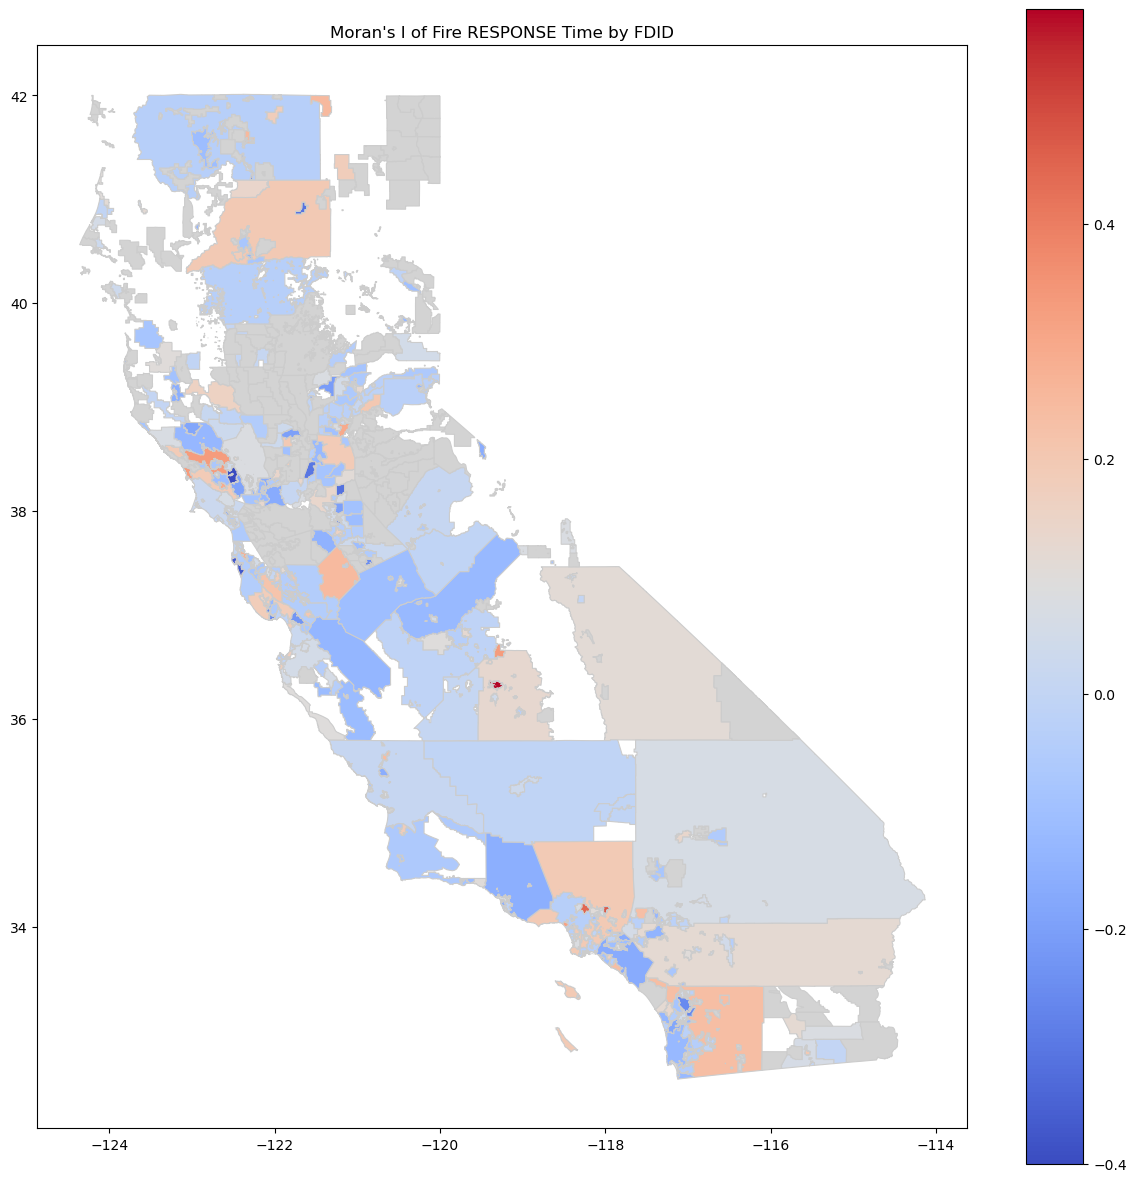

In [14]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2020/morans_i_results2020_rt.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire RESPONSE Time by FDID')
plt.show()


In [15]:
#============='FIRE_CLEARANCE_TIME'===============

In [16]:
import dask.dataframe as dd

# 使用Dask读取合并后的数据
merged_data_file = 'morans_data/2020/merged_fire_data_2020.csv'
merged = dd.read_csv(merged_data_file)

# 确保Dask dataframe中FDID是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  
0                 16.0  
1                 27.0  
2                 21.0  
3                 14.0  
4                 89.0  


In [17]:
# 为 FDID 生成一个索引
fdid_unique = merged['FDID'].unique().compute()
fdid_index = {fdid: idx for idx, fdid in enumerate(fdid_unique)}
merged['FDID_index'] = merged['FDID'].map(fdid_index)

# 显示前几行，确保索引正确生成
print(merged.head())


    FDID                                           geometry  RESPONSE_TIME  \
0  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            6.0   
1  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
2  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            5.0   
3  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   
4  10005  MULTIPOLYGON (((34471.40500000119 -135546.3414...            4.0   

   FIRE_CLEARANCE_TIME  FDID_index  
0                 16.0           0  
1                 27.0           0  
2                 21.0           0  
3                 14.0           0  
4                 89.0           0  


In [18]:
import numpy as np
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 定义计算 Moran's I 的函数
def compute_moran(chunk):
    fdid_index_values = chunk['FDID_index'].values
    y_response = chunk['FIRE_CLEARANCE_TIME'].values
    
    # 创建权重矩阵
    coords = np.array(list(enumerate(fdid_index_values)))
    w = DistanceBand(coords, threshold=1.5, binary=True, silence_warnings=True)
    
    moran_response = Moran(y_response, w)
    return moran_response.I, moran_response.p_norm


In [19]:
# 分块计算 Moran's I
results = merged.map_partitions(compute_moran, meta=('I', 'f8')).compute()

# 显示计算结果
print(results)


0                                        (nan, nan)
1        (-0.0999369179060061, 0.07671742860915658)
2        (-0.006641431309501028, 0.947154582603654)
3       (-0.007593046374643552, 0.9333275872844959)
4          (0.09902244357678788, 0.062041770486342)
                           ...                     
989     (0.09460987350434975, 0.011831083560053112)
990     (-0.007680702420636762, 0.9038449674045093)
991    (-0.0013370274716458129, 0.9842449381975404)
992      (0.03078322743613254, 0.34686811602644163)
993                                      (nan, nan)
Length: 994, dtype: object


In [20]:
import pandas as pd
# 将结果转换为 DataFrame
results_df = pd.DataFrame(results.tolist(), columns=['Moran_I', 'p_value'])

# 添加 FDID 列
results_df['FDID'] = merged['FDID'].unique().compute()

# 保存结果到 CSV 文件
results_df.to_csv('morans_data/2020/morans_i_results2020_clear.csv', index=False)

In [21]:
# 过滤掉包含 nan 的结果
filtered_results = [res for res in results if not np.isnan(res[0]) and not np.isnan(res[1])]

# 检查是否有有效的结果
if filtered_results:
    # 计算总体的 Moran's I 平均值
    average_moran_i = np.mean([res[0] for res in filtered_results])
    average_p_value = np.mean([res[1] for res in filtered_results])

    # 输出结果
    print(f"Average Fire Clearance Time Moran's I: {average_moran_i}")
    print(f"Average Fire Clearance Time P-value: {average_p_value}")

    if average_p_value < 0.05:
        print("存在显著的火灾清除时间空间自相关")
    else:
        print("没有显著的火灾清除时间空间自相关")
else:
    print("所有分区的计算结果都包含 nan 值，无法计算总体的 Moran's I 平均值。")


Average Fire Clearance Time Moran's I: 0.015087483139679789
Average Fire Clearance Time P-value: 0.584682368903074
没有显著的火灾清除时间空间自相关


In [22]:
import geopandas as gpd

# 读取Shapefile文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保GeoDataFrame中FDID是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 显示前几行，确保数据正确读取
print(gdf.head())


    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOITO  (510) 528-5770   

  Notes  LastUpdate                                            Website  \
0   NaN  2018-06-21                                             <Null>   
1   

In [23]:
import dask.dataframe as dd
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand
from esda.moran import Moran

# 使用 Dask 读取合并后的数据，这里包含response time
merged_data_file = 'morans_data/2020/merged_fire_data_2020.csv'
merged = dd.read_csv(merged_data_file)

# 确保 Dask DataFrame 中 FDID 是字符串类型
merged['FDID'] = merged['FDID'].astype(str)

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)


    Moran_I   p_value   FDID
0       NaN       NaN  10005
1 -0.099937  0.076717  10010
2 -0.006641  0.947155  10020
3 -0.007593  0.933328  10030
4  0.099022  0.062042  10040
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

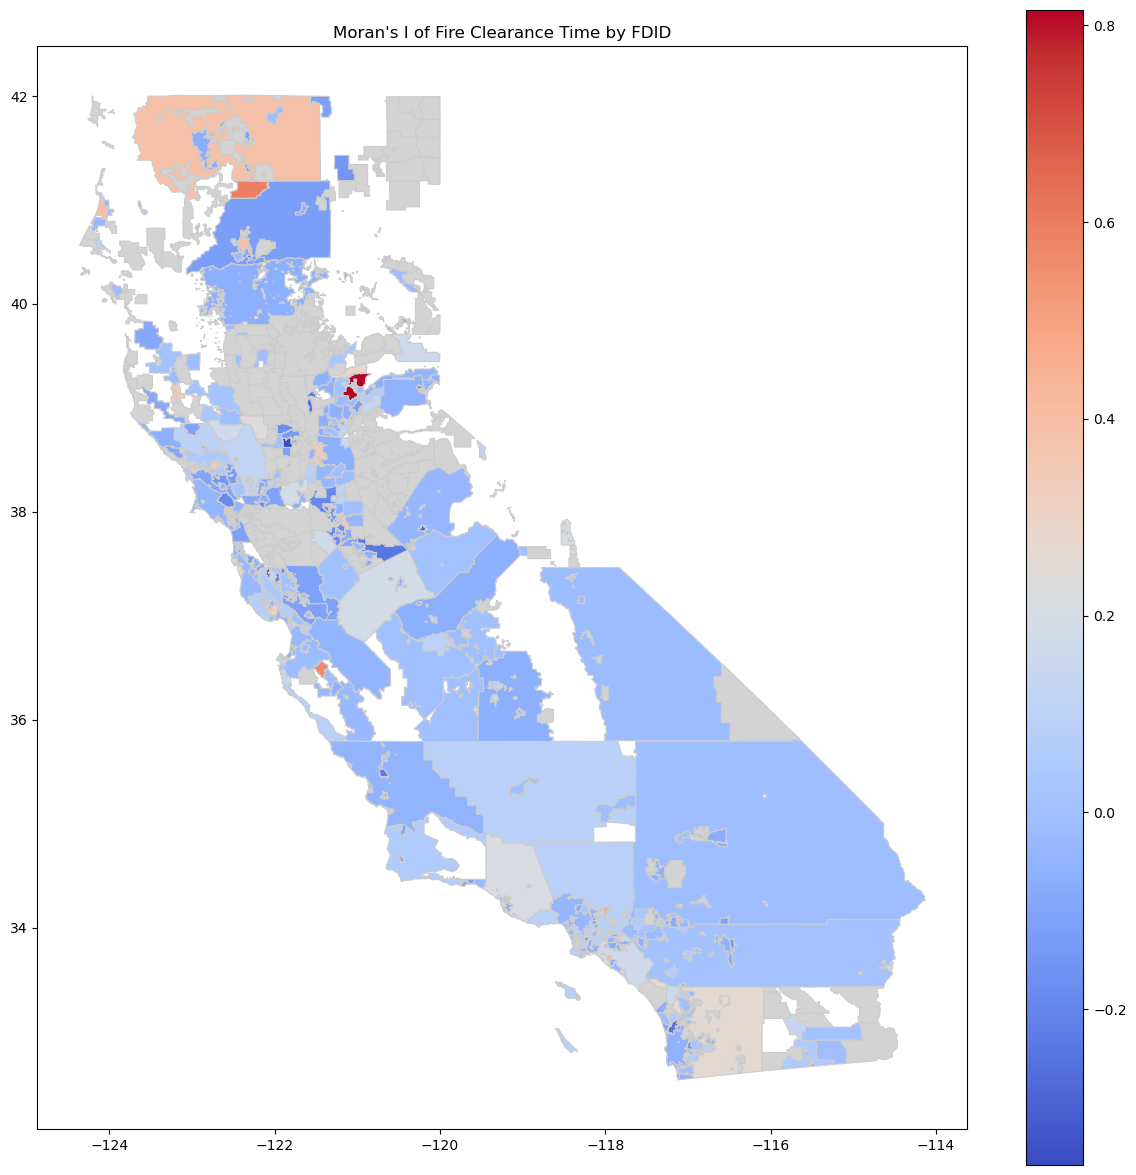

In [24]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2020/morans_i_results2020_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID')
plt.show()


    Moran_I   p_value   FDID
0       NaN       NaN  10005
1 -0.099937  0.076717  10010
2 -0.006641  0.947155  10020
3 -0.007593  0.933328  10030
4  0.099022  0.062042  10040
    County   FDID MACSID                               Name  \
0  ALAMEDA    nan    NaN               CAMP PARKS FIRE DEPT   
1  ALAMEDA    nan    NaN  FAIRVIEW FIRE PROTECTION DISTRICT   
2  ALAMEDA  01005    ALA                         ALAMEDA FD   
3  ALAMEDA  01008    ACF                  ALAMEDA COUNTY FD   
4  ALAMEDA  01010    ALB                  CITY OF ALBANY FD   

              Address     City    Zip            FireChief           Phone  \
0                 NaN      NaN    NaN                  NaN             NaN   
1                 NaN      NaN    NaN                  NaN  (510) 583-4940   
2        1300 PARK ST  ALAMEDA  94501        NICHOLAS LUBY  (510) 337-2100   
3      6363 CLARK AVE   DUBLIN  94568  WILLIAM L. MCDONALD  (925) 833-3473   
4  1000 SAN PABLO AVE   ALBANY  94706          JAMES BOIT

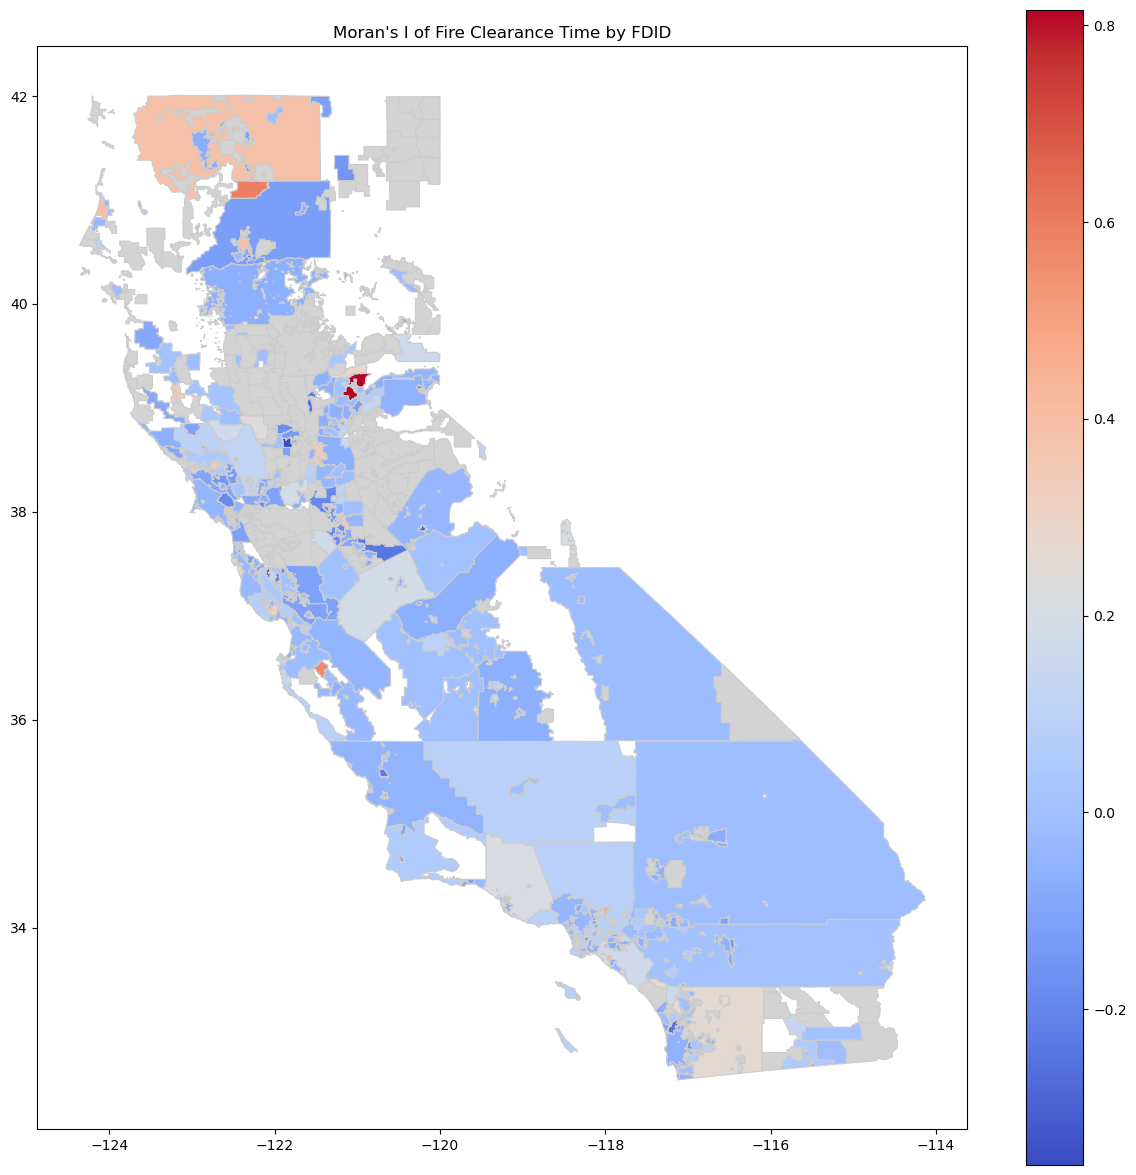

In [25]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 读取 Shapefile 文件
shapefile_path = 'california_shapefile/FireDistricts24_1.shp'
gdf = gpd.read_file(shapefile_path)

# 确保 GeoDataFrame 中 FDID 是字符串类型
gdf['FDID'] = gdf['FDID'].astype(str)

# 检查并设置 CRS 为 EPSG:4326
gdf = gdf.to_crs(epsg=4326)

# 读取保存的 Moran's I 结果
results_df = pd.read_csv('morans_data/2020/morans_i_results2020_clear.csv')

# 过滤掉包含空白 FDID 的行
results_df = results_df[results_df['FDID'].notna()]

# 将 FDID 转换为整数类型并再转换为字符串类型
results_df['FDID'] = results_df['FDID'].astype(int).astype(str)

# 检查合并前的数据
print(results_df.head())
print(gdf.head())

# 将 Moran's I 结果合并到 GeoDataFrame 中
gdf = gdf.merge(results_df, on='FDID', how='left')

# 检查合并后的数据
print(gdf.head())

# 绘制地图，展示 Moran's I 结果，设置缺失数据的颜色
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
gdf.plot(column='Moran_I', cmap='coolwarm', linewidth=0.8, ax=ax, edgecolor='0.8', legend=True, 
         missing_kwds={"color": "lightgrey", "label": "No data"})
ax.set_title('Moran\'s I of Fire Clearance Time by FDID')
plt.show()
